In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import re
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
colors = sns.color_palette("viridis", 10)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'sans-serif'

# Load the PR dataset
df = pd.read_csv('DATA/pr_analysis_full_data.csv')
print(f"Loaded {len(df)} pull requests")

# Parse the qualitative analysis results
def parse_markdown_table(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Extract table rows containing category stats
    pattern = r'\|\s*([^|]+)\s*\|\s*(\d+\.?\d*)\s*\|\s*(\d+\.?\d*)%\s*\|'
    matches = re.findall(pattern, content)
    
    data = []
    for match in matches:
        category = match[0].strip()
        count = float(match[1])
        percentage = float(match[2])
        data.append({
            'Category': category,
            'Count': count,
            'Percentage': percentage
        })
    
    return pd.DataFrame(data)

qual_df = parse_markdown_table('data/pr_comment_analysis_report.md')
qual_df = qual_df.sort_values('Percentage', ascending=False)
print("Loaded qualitative analysis results")

# Parse the change_request_categories column
def parse_categories(text):
    if pd.isna(text) or text == '{}':
        return {}
    try:
        return ast.literal_eval(text)
    except:
        try:
            return json.loads(text.replace("'", '"'))
        except:
            return {}

df['parsed_categories'] = df['change_request_categories'].apply(parse_categories)

# all categories from the full dataset
auto_categories = {}
for categories_dict in df['parsed_categories']:
    for category, count in categories_dict.items():
        if category in auto_categories:
            auto_categories[category] += count
        else:
            auto_categories[category] = count

auto_df = pd.DataFrame({
    'Category': list(auto_categories.keys()),
    'Count': list(auto_categories.values())
})
auto_df['Percentage'] = (auto_df['Count'] / len(df) * 100).round(1)
auto_df = auto_df.sort_values('Count', ascending=False)

Loaded 860 pull requests
Loaded qualitative analysis results


<Figure size 1400x800 with 0 Axes>

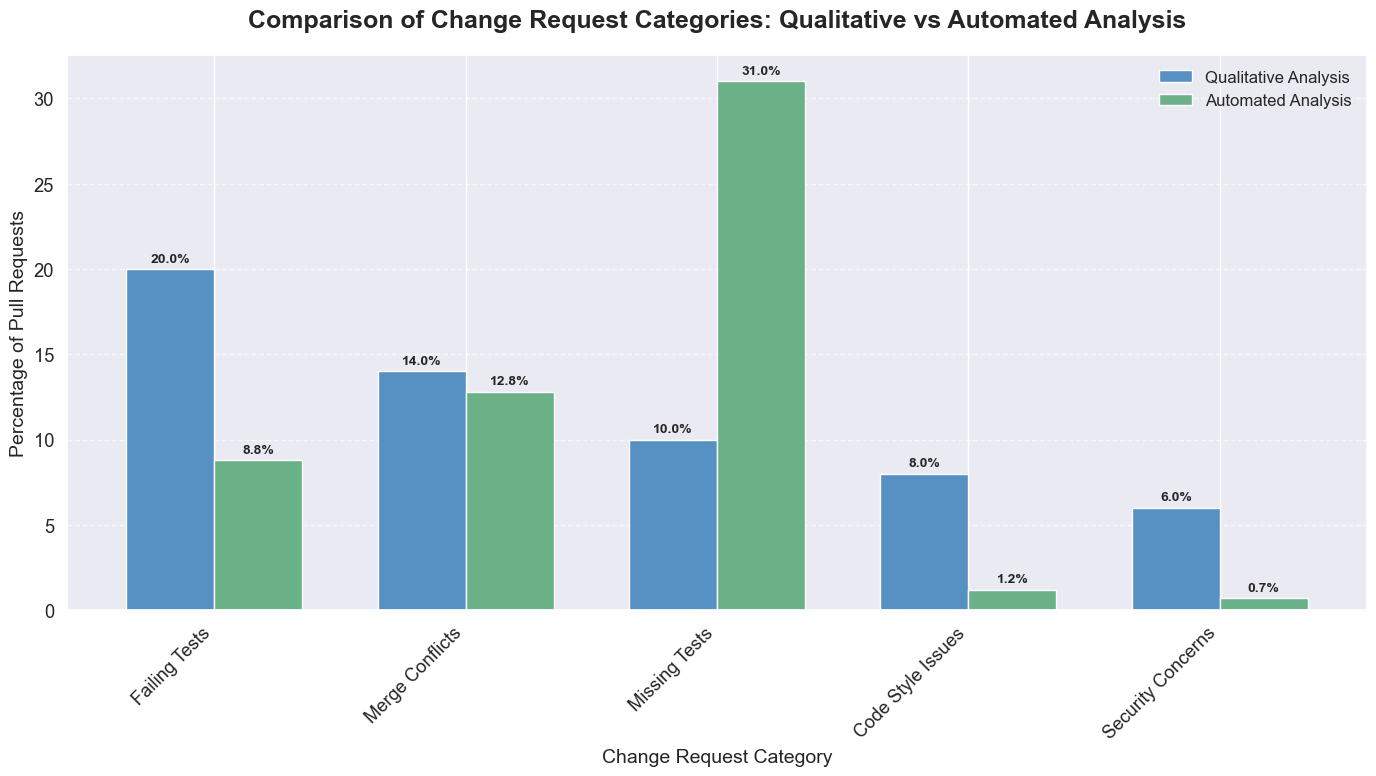

In [42]:
category_mapping = {
    'Missing Tests': 'Missing Tests',
    'Failing Tests': 'Failing Tests',
    'Code Style Issues': 'Code Style Issues',
    'Documentation Issues': 'Documentation Issues',
    'Logic Errors': 'Logic Errors',
    'Merge Conflicts': 'Merge Conflicts',
    'Performance Issues': 'Performance Issues',
    'Security Concerns': 'Security Issues',
}

# Create comparison data
comparison_data = []
for qual_cat, auto_cat in category_mapping.items():
    if auto_cat is not None and auto_cat in auto_df['Category'].values:
        qual_pct = qual_df[qual_df['Category'] == qual_cat]['Percentage'].values[0] if qual_cat in qual_df['Category'].values else 0
        auto_pct = auto_df[auto_df['Category'] == auto_cat]['Percentage'].values[0]
        comparison_data.append({
            'Category': qual_cat,
            'Qualitative': qual_pct,
            'Automated': auto_pct
        })

comp_df = pd.DataFrame(comparison_data)
comp_df = comp_df.sort_values('Qualitative', ascending=False)

# Create grouped bar chart
plt.figure(figsize=(14, 8))
x = np.arange(len(comp_df))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, comp_df['Qualitative'], width, label='Qualitative Analysis', color='#5790C2')
rects2 = ax.bar(x + width/2, comp_df['Automated'], width, label='Automated Analysis', color='#6AB187')

# Add labels and styling
ax.set_title('Comparison of Change Request Categories: Qualitative vs Automated Analysis', fontsize=18, fontweight='bold', pad=20)
ax.set_ylabel('Percentage of Pull Requests', fontsize=14)
ax.set_xlabel('Change Request Category', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comp_df['Category'], rotation=45, ha='right')
ax.legend(fontsize=12)

# Add value labels on bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                   xy=(rect.get_x() + rect.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

add_labels(rects1)
add_labels(rects2)

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('comparison_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

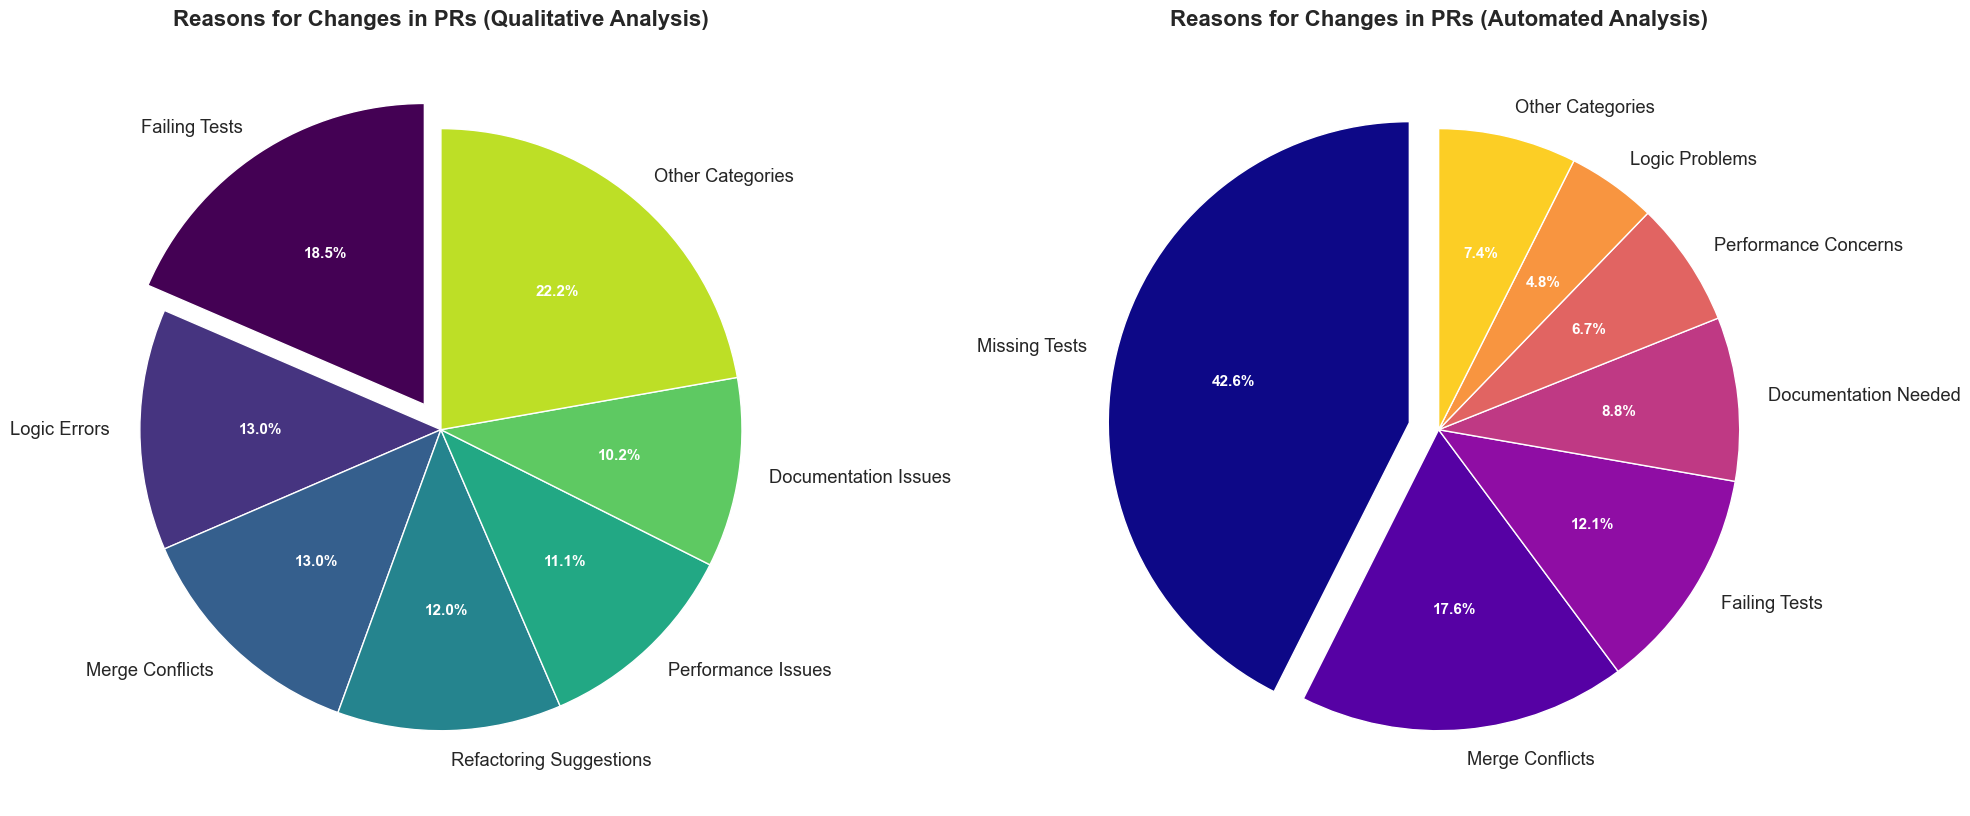

In [43]:
# Create pie charts for qualitative and automated analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Qualitative Analysis Pie Chart
qual_data = qual_df.head(6)  
others_sum = qual_df.iloc[6:]['Percentage'].sum() if len(qual_df) > 6 else 0
if others_sum > 0:
    qual_data = pd.concat([qual_data, pd.DataFrame([{'Category': 'Other Categories', 'Count': 0, 'Percentage': others_sum}])])

explode = [0.1 if i == 0 else 0 for i in range(len(qual_data))]  
colors = plt.cm.viridis(np.linspace(0, 0.9, len(qual_data)))

wedges, texts, autotexts = ax1.pie(
    qual_data['Percentage'], 
    labels=qual_data['Category'], 
    autopct='%1.1f%%',
    explode=explode,
    colors=colors,
    startangle=90,
    shadow=False,
    wedgeprops={'edgecolor': 'w', 'linewidth': 1}
)

for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

ax1.set_title('Reasons for Changes in PRs (Qualitative Analysis)', fontsize=16, fontweight='bold', pad=20)

# Automated Analysis Pie Chart
auto_data = auto_df.head(6) 
others_sum = auto_df.iloc[6:]['Percentage'].sum() if len(auto_df) > 6 else 0
if others_sum > 0:
    auto_data = pd.concat([auto_data, pd.DataFrame([{'Category': 'Other Categories', 'Count': 0, 'Percentage': others_sum}])])

explode = [0.1 if i == 0 else 0 for i in range(len(auto_data))]  
colors = plt.cm.plasma(np.linspace(0, 0.9, len(auto_data)))

wedges, texts, autotexts = ax2.pie(
    auto_data['Percentage'], 
    labels=auto_data['Category'], 
    autopct='%1.1f%%',
    explode=explode,
    colors=colors,
    startangle=90,
    shadow=False,
    wedgeprops={'edgecolor': 'w', 'linewidth': 1}
)

for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

ax2.set_title('Reasons for Changes in PRs (Automated Analysis)', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('category_pies.png', dpi=300, bbox_inches='tight')
plt.show()

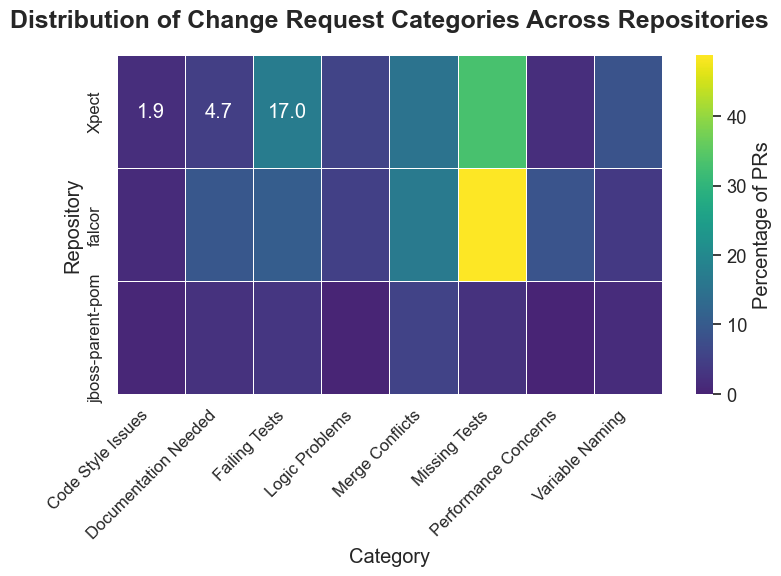

In [46]:
# Prepare repository-specific data
repo_categories = {}
for repo in df['repository'].unique():
    repo_df = df[df['repository'] == repo]
    repo_cats = {}
    
    for categories_dict in repo_df['parsed_categories']:
        for category, count in categories_dict.items():
            if category in repo_cats:
                repo_cats[category] += count
            else:
                repo_cats[category] = count
    
    # Calculate percentages relative to repository size
    repo_size = len(repo_df)
    repo_categories[repo] = {cat: (count / repo_size * 100) for cat, count in repo_cats.items()}

# Create pivot table for heatmap
top_categories = auto_df.head(8)['Category'].tolist()
heatmap_data = []

for repo, categories in repo_categories.items():
    repo_name = repo.split('/')[-1]  # Just use the project name, not the full path
    for category in top_categories:
        percentage = categories.get(category, 0)
        heatmap_data.append({
            'Repository': repo_name,
            'Category': category,
            'Percentage': percentage
        })

heat_df = pd.DataFrame(heatmap_data)
pivot_table = heat_df.pivot(index='Repository', columns='Category', values='Percentage')

# Create heatmap
plt.figure(figsize=(8, 6))
custom_cmap = LinearSegmentedColormap.from_list('custom_viridis', 
                                              plt.cm.viridis(np.linspace(0.1, 1, 100)))

ax = sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap=custom_cmap, 
                linewidths=.5, cbar_kws={'label': 'Percentage of PRs'})

# 
ax.set_title('Distribution of Change Request Categories Across Repositories', fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('repo_category_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()